In [1]:
import sys
sys.version

'3.5.2 (default, Oct  8 2019, 13:06:37) \n[GCC 5.4.0 20160609]'

In [2]:
import numpy as np
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'
import tensorflow as tf
# from tensorflow.compat.v1 import InteractiveSession
# config = tf.compat.v1.ConfigProto()
# config.gpu_options.allow_growth = True
# sess = tf.compat.v1.Session(config=config)
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Activation
from keras.layers import Dense, Flatten
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import *
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
%matplotlib inline

/home/dhanashree/MyFolder/Dev/video_classification/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/dhanashree/MyFolder/Dev/video_classification/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/dhanashree/MyFolder/Dev/video_classification/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)]

In [3]:
from tensorflow.compat.v1 import InteractiveSession
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)

In [4]:
keras.__version__

'2.3.1'

In [5]:
# Just disables the warning, doesn't enable AVX/FMA
import tensorflow as tf
import os
tf.__version__
#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

'1.13.1'

In [6]:
%pwd

'/home/dhanashree/MyFolder/Dev/atoz/digits_training'

In [7]:
# %%bash
# cd Sign-Language-Digits-Dataset/train/
# for i in {9..9};
# do
#     #d=`expr $i + 65`
#     #c=$(printf \\$(printf '%03o' $d))
#     # c="space"
#     a=$(find $i/ -type f | shuf -n 30)
#     mv $a ../valid/$i/
#     b=$(find $i/ -type f | shuf -n 5)
#     mv $b ../test/$i/
# done

In [8]:
train_path = 'Sign-Language-Digits-Dataset1/train'
valid_path = 'Sign-Language-Digits-Dataset1/valid'
test_path = 'Sign-Language-Digits-Dataset1/test'

In [9]:
train_batches = ImageDataGenerator().flow_from_directory(train_path, target_size=(224,224), classes=['0','1','2','3','4','5','6','7','8','9'], batch_size=10)
valid_batches = ImageDataGenerator().flow_from_directory(valid_path, target_size=(224,224), classes=['0','1','2','3','4','5','6','7','8','9'], batch_size=10)
test_batches = ImageDataGenerator().flow_from_directory(test_path, target_size=(224,224), classes=['0','1','2','3','4','5','6','7','8','9'], batch_size=10, shuffle=False)

Found 2050 images belonging to 10 classes.
Found 300 images belonging to 10 classes.
Found 200 images belonging to 10 classes.


In [10]:
#plots images with labels within jupyter notebook
def plots(ims, figsize=(12,6), rows=1, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

In [11]:
(imgs, labels) = next(train_batches)

/home/dhanashree/MyFolder/Dev/video_classification/lib/python3.5/site-packages/matplotlib/text.py:1191: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


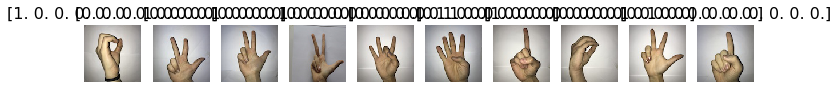

In [12]:
plots(imgs, titles=labels)

In [17]:
# (imgs, lbls) = next(test_batches)

In [18]:
# plt.imshow(imgs[0])

## Build Fine-tuned VGG16 model

In [15]:
vgg16_model = keras.applications.vgg16.VGG16()

Instructions for updating:
Colocations handled automatically by placer.


In [16]:
vgg16_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [17]:
type(vgg16_model)

keras.engine.training.Model

In [18]:
vgg16_model.layers.pop()

In [19]:
# vgg16_model.outputs = [vgg16_model.layers[-6].output]
vgg16_model.layers[-1].outbound_nodes = []
#vgg16_model.add(Dense(26, activation='softmax'))

### converted keras.engine.training.Model type to Sequential

In [20]:
model = Sequential()
for layer in vgg16_model.layers:
    model.add(layer)

In [21]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)      

In [22]:
type(model)

keras.engine.sequential.Sequential

### keep all the weights of trained model as it is...dont change it

In [23]:
for layer in model.layers[:-18]:
    layer.trainable = False

In [24]:
model.add(Dense(10, activation='softmax'))

In [25]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)      

In [27]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

model.compile(Adam(lr=.0001), loss='categorical_crossentropy', metrics=['accuracy', f1_m, precision_m, recall_m])

In [27]:
session = keras.backend.get_session()
init = tf.global_variables_initializer()
session.run(init)

In [28]:
from tensorflow.python.keras.backend import set_session
from tensorflow.python.keras.models import load_model

tf_config = tf.compat.v1.ConfigProto()
sess = tf.Session(config=tf_config)
graph = tf.get_default_graph()

In [29]:
from tensorflow.python.keras.backend import set_session
from tensorflow.python.keras.models import load_model
#tf_config = some_custom_config
config = tf.compat.v1.ConfigProto()
sess = tf.compat.v1.Session(config=config)
graph = tf.compat.v1.get_default_graph()

# IMPORTANT: models have to be loaded AFTER SETTING THE SESSION for keras! 
# Otherwise, their weights will be unavailable in the threads after the session there has been set
set_session(sess)

In [30]:
# import tensorflow as tf
# gpu_devices = tf.config.experimental.list_physical_devices('GPU')
# for device in gpu_devices: tf.config.experimental.set_memory_growth(device, True)

In [31]:
session = keras.backend.get_session()
init = tf.global_variables_initializer()
session.run(init)

In [32]:
model.fit_generator(train_batches, steps_per_epoch=30, validation_data=valid_batches, validation_steps=30, epochs=100, verbose=2)

Instructions for updating:
Use tf.cast instead.
Epoch 1/100
 - 35s - loss: 2.4943 - accuracy: 0.0900 - val_loss: 2.3110 - val_accuracy: 0.1000
Epoch 2/100
 - 17s - loss: 2.3027 - accuracy: 0.1167 - val_loss: 2.2929 - val_accuracy: 0.1000
Epoch 3/100
 - 17s - loss: 2.3042 - accuracy: 0.1367 - val_loss: 2.2756 - val_accuracy: 0.1000
Epoch 4/100
 - 17s - loss: 2.2157 - accuracy: 0.2333 - val_loss: 1.6116 - val_accuracy: 0.3467
Epoch 5/100
 - 17s - loss: 1.3911 - accuracy: 0.5167 - val_loss: 1.2322 - val_accuracy: 0.6533
Epoch 6/100
 - 17s - loss: 0.9093 - accuracy: 0.7200 - val_loss: 0.5205 - val_accuracy: 0.7967
Epoch 7/100
 - 17s - loss: 0.5721 - accuracy: 0.8100 - val_loss: 1.9271 - val_accuracy: 0.8433
Epoch 8/100
 - 17s - loss: 0.6111 - accuracy: 0.8367 - val_loss: 0.4147 - val_accuracy: 0.8767
Epoch 9/100
 - 17s - loss: 0.3931 - accuracy: 0.8633 - val_loss: 0.7237 - val_accuracy: 0.9033
Epoch 10/100
 - 17s - loss: 0.2590 - accuracy: 0.9133 - val_loss: 0.1846 - val_accuracy: 0.8100
E

Epoch 83/100
 - 17s - loss: 0.0104 - accuracy: 0.9967 - val_loss: 0.0013 - val_accuracy: 0.9633
Epoch 84/100
 - 17s - loss: 0.0530 - accuracy: 0.9900 - val_loss: 0.0224 - val_accuracy: 0.9700
Epoch 85/100
 - 17s - loss: 0.0375 - accuracy: 0.9867 - val_loss: 1.6321e-04 - val_accuracy: 0.9900
Epoch 86/100
 - 17s - loss: 0.0100 - accuracy: 0.9967 - val_loss: 2.9544e-04 - val_accuracy: 0.9933
Epoch 87/100
 - 17s - loss: 0.0323 - accuracy: 0.9933 - val_loss: 0.5014 - val_accuracy: 0.9767
Epoch 88/100
 - 17s - loss: 0.0293 - accuracy: 0.9967 - val_loss: 5.1058e-05 - val_accuracy: 0.9867
Epoch 89/100
 - 17s - loss: 5.3388e-04 - accuracy: 1.0000 - val_loss: 1.6689e-07 - val_accuracy: 0.9933
Epoch 90/100
 - 17s - loss: 0.1236 - accuracy: 0.9667 - val_loss: 0.0963 - val_accuracy: 0.9767
Epoch 91/100
 - 17s - loss: 0.0717 - accuracy: 0.9767 - val_loss: 0.0027 - val_accuracy: 0.9933
Epoch 92/100
 - 17s - loss: 0.0566 - accuracy: 0.9867 - val_loss: 0.0014 - val_accuracy: 0.9633
Epoch 93/100
 - 17s 

In [33]:
model.save('1_10_digit_train_4.h5')

In [13]:
from keras.models import load_model
from tensorflow.python.keras.backend import set_session


config = tf.compat.v1.ConfigProto()
sess = tf.compat.v1.Session(config=config)
vgg16_model = keras.applications.vgg16.VGG16()
vgg16_model.layers.pop()
#vgg16_model.outputs = [vgg16_model.layers[-6].output]
vgg16_model.layers[-1].outbound_nodes = []
model = Sequential()
for layer in vgg16_model.layers:
    model.add(layer)
for layer in model.layers[:-18]:
    layer.trainable = False
model.add(Dense(10, activation='softmax'))
set_session(sess)
model.load_weights('/home/dhanashree/MyFolder/Dev/atoz/digits_training/1_10_digit_train_4.h5')

Instructions for updating:
Colocations handled automatically by placer.


In [14]:
test_labels = test_batches.classes

In [15]:
test_labels.shape

(200,)

In [16]:
test_batches.class_indices

{'0': 0,
 '1': 1,
 '2': 2,
 '3': 3,
 '4': 4,
 '5': 5,
 '6': 6,
 '7': 7,
 '8': 8,
 '9': 9}

In [17]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plot confusion matrix
    Normalization can be applied by setting 'normalize=True'
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks=np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
        
    print(cm)
    
    thresh = cm.max() / 2
    for i,j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
        
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

In [18]:
predictions = model.predict_generator(test_batches, steps=20, verbose=2)

In [19]:
pre=predictions.argmax(axis=1)

In [20]:
test_batches

In [21]:
predictions.shape

(200, 10)

In [22]:
pre

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 6, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
       9, 9])

In [23]:
test_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
       9, 9], dtype=int32)

In [24]:
predictions[0].argmax()

0

In [25]:
#cm = confusion_matrix(test_labels, predictions.argmax(axis=1))
cm = confusion_matrix(test_labels, pre, labels=[0,1,2,3,4,5,6,7,8,9])

Confusion matrix, without normalization
[[20  0  0  0  0  0  0  0  0  0]
 [ 0 20  0  0  0  0  0  0  0  0]
 [ 0  0 20  0  0  0  0  0  0  0]
 [ 0  0  0 20  0  0  0  0  0  0]
 [ 0  0  0  0 19  0  1  0  0  0]
 [ 0  0  0  0  0 20  0  0  0  0]
 [ 0  0  0  0  0  0 20  0  0  0]
 [ 0  0  0  0  0  0  0 20  0  0]
 [ 0  0  0  0  0  0  0  0 20  0]
 [ 0  0  0  0  0  0  0  0  0 20]]


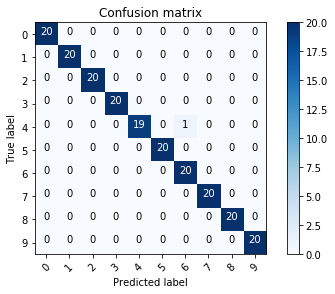

In [26]:
lbls=['0','1','2','3','4','5','6','7','8','9']
plot_confusion_matrix(cm,lbls,title='Confusion matrix')

In [ ]:
# from keras import backend as K

# def recall_m(y_true, y_pred):
#     true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
#     possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
#     recall = true_positives / (possible_positives + K.epsilon())
#     return recall

# def precision_m(y_true, y_pred):
#     true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
#     predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
#     precision = true_positives / (predicted_positives + K.epsilon())
#     return precision

# def f1_m(y_true, y_pred):
#     precision = precision_m(y_true, y_pred)
#     recall = recall_m(y_true, y_pred)
#     return 2*((precision*recall)/(precision+recall+K.epsilon()))

# # compile the model
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc',f1_m,precision_m, recall_m])

# # fit the model
# history = model.fit(Xtrain, ytrain, validation_split=0.3, epochs=10, verbose=0)

# # evaluate the model
# loss, accuracy, f1_score, precision, recall = model.evaluate(Xtest, ytest, verbose=0)


In [32]:
model.evaluate(test_batches)

20/20 [==============================] - 3s 170ms/step


[1.1920930376163597e-07, 0.9950000047683716]

In [28]:
model.evaluate(test_batches)

20/20 [==============================] - 81s 4s/step


[1.1920928955078125e-07,
 0.9950000047683716,
 0.9950000047683716,
 0.9950000047683716,
 0.9950000047683716]